In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

con = sqlite3.connect('C:/Users/DELL/Desktop/appliedAi/Data set/Amazon/database.sqlite') 
filteredData = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con)
#filteredData=filteredData.iloc[0:3000,:]
#filteredData.shape               
dfScore=filteredData['Score']


def convertPositiveNegative(x):
    if x < 3:
        return 'negative'
    return 'positive'
dfPositiveNegative=dfScore.map(convertPositiveNegative)




filteredData['Score']=dfPositiveNegative


   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
0                     1                       1  positive  1303862400   
1                     0                       0  negative  1346976000   
2                     1                       1  positive  1219017600   
3                     3                       3  negative  1307923200   
4                     0                       0  positive  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitalit

In [2]:
sorted_data=filteredData.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [3]:
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

In [4]:
(final['Id'].size*1.0)/(filteredData['Id'].size*1.0)*100

69.25890143662969

In [5]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [6]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import nltk
nltk.download('stopwords')
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''

for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    
    
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    
    final_string.append(str1)
    i+=1

In [8]:
final['CleanedText']=final_string

In [9]:
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [10]:
final=final.sort_values(by='Time')

In [11]:
final=final.iloc[0:100000,:]

In [12]:
final['Score_num']=final.Score.map({'positive':1, 'negative':0})
Y=final['Score_num']

In [16]:
X_train=final.iloc[0:60000]
Y_train=final['Score_num'].iloc[0:60000]

In [19]:
X_test=final.iloc[60001:99999]
Y_test=final['Score_num'].iloc[60001:99999]

In [20]:
count_vect = TfidfVectorizer() #in scikit-learn
X_train_vect = count_vect.fit_transform(X_train['CleanedText'].values)

In [21]:
X_test_vect=count_vect.transform(X_test['CleanedText'].values)

In [22]:
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [23]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]

model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1', cv=5)
model.fit(X_train_vect, Y_train)
print(model.best_estimator_)
print(model.score(X_test_vect, Y_test))

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.9536607192796017


In [24]:
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import RandomizedSearchCV

param_grid = {'alpha': sp_rand()}

# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter distribution using uniform distribution
C = sp_rand(loc=0, scale=4)

# Create hyperparameter options
hyperparameters = dict(C=C)
#clf = LogisticRegression( penalty='l1');

model_random = RandomizedSearchCV(LogisticRegression(),hyperparameters,n_iter=100, cv=5)
model_random.fit(X_train_vect, Y_train)
print(model.best_estimator_)
print(model.score(X_test_vect, Y_test))

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.9536607192796017


In [25]:
clf_model=LogisticRegression(C=1, penalty='l1')
clf = clf_model.fit(X_train_vect, Y_train)
acc = clf.score(X_test_vect, Y_test)
print(acc)
w = clf.coef_

0.9196709835491774


In [26]:
X_train_vect_pert1=X_train_vect

# adding a noise for collinearity

In [27]:
X_train_vect_pert1.data=X_train_vect_pert1.data+0.1

In [28]:
# training new mpdel
clf_model_pert=LogisticRegression(C=0.01, penalty='l1')
clf_pert = clf_model_pert.fit(X_train_vect_pert1,Y_train)
#acc = clf.score(X_test_vect, Y_tet)
#print(acc)
w_pert = clf_pert.coef_

In [29]:
diff=(w_pert)-(w)

In [30]:
# diving by earlier weights 
#try:
percen=np.divide(diff,w)
#except ZeroDivisionError:
#     percen=0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [31]:
percen[np.isnan(percen)] = 0

In [32]:
percen_mean=np.mean(percen)

In [33]:
abs(percen_mean*100)
# we are getting only 3% so we can ignore collinearity 

3.9224094970007624

In [34]:
from sklearn.preprocessing import Normalizer
transformer_tfidf = Normalizer().fit(X_train_vect)
X_train_vect_norm_tfidf=transformer_tfidf.transform(X_train_vect)

Normalizer(copy=True, norm='l2')


In [35]:
X_test_vect_norm_tfidf=transformer_tfidf.transform(X_test_vect)

In [36]:
clf_model=LogisticRegression(C=0.01, penalty='l1')
clf = clf_model.fit(X_train_vect_norm_tfidf, Y_train)
acc = clf.score(X_test_vect_norm_tfidf, Y_test)
w = clf.coef_

0.8645432271613581


In [37]:
clf_model=LogisticRegression(C=0.0001, penalty='l2')
clf = clf_model.fit(X_train_vect_norm_tfidf, Y_train)
acc = clf.score(X_test_vect_norm_tfidf, Y_test)
w = clf.coef_

0.8645432271613581


In [38]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    labels = [1,2]
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [39]:
clf_model=LogisticRegression(C=1, penalty='l1')
clf = clf_model.fit(X_train_vect_norm_tfidf, Y_train)
Y_predict=clf_model.predict(X_test_vect_norm_tfidf)

-------------------- Confusion matrix --------------------


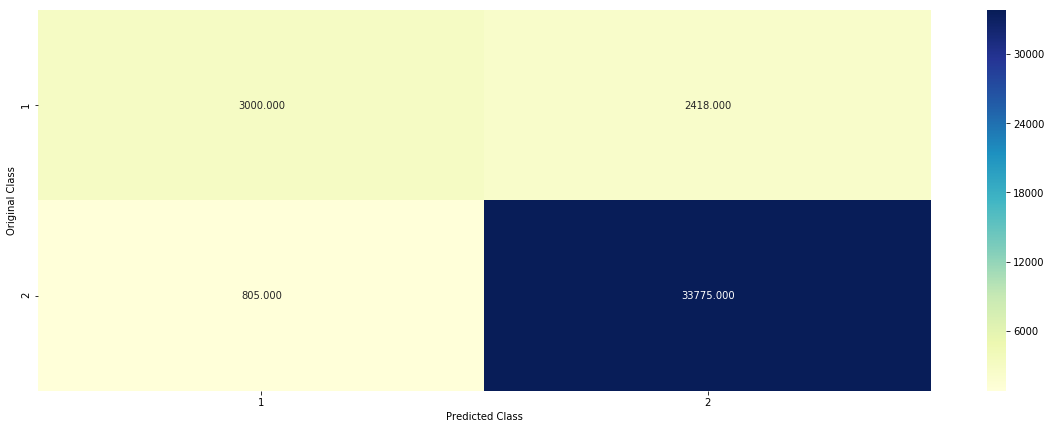

-------------------- Precision matrix (Columm Sum=1) --------------------


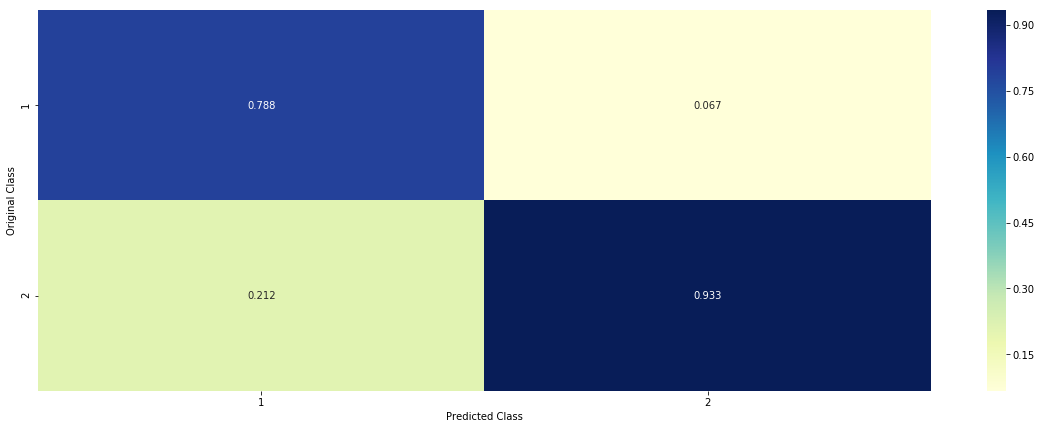

-------------------- Recall matrix (Row sum=1) --------------------


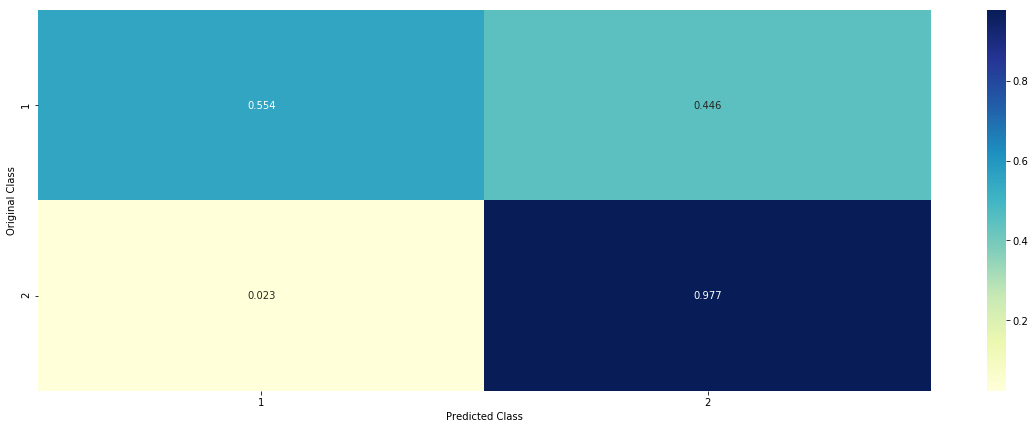

In [40]:
plot_confusion_matrix(Y_test,Y_predict)

# Conclusion based on tfidf 
Model-Logistic regression 
Hyperparameter-c=1
test error- data points who were positive but were given negative are only 0.66
            data points who were negative but were given positive are only 0.184

# word2vec

In [41]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [42]:
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [43]:
X_train_word2vec=final.iloc[0:60000]
Y_train_word2vec=final['Score_num'].iloc[0:60000]
X_test_word2vec=final.iloc[60001:99999]
Y_test_word2vec=final['Score_num'].iloc[60001:99999]


In [44]:
list_of_sent_X_train_word2vec=[]
list_of_sent_X_test_word2vec=[]
for sent in X_train_word2vec['CleanedText'].values:
    list_of_sent_X_train_word2vec.append(sent.split())

for sent in X_test_word2vec['CleanedText'].values:
    list_of_sent_X_test_word2vec.append(sent.split())

In [45]:
w2v_model=Word2Vec(list_of_sent_X_train_word2vec,min_count=5,size=50, workers=4)

In [46]:
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_X_train_word2vec: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)

In [47]:
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_X_test_word2vec: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)

In [48]:
from sklearn.preprocessing import Normalizer
transformer_word2vec = Normalizer().fit(sent_vectors_train)
X_train_vect_norm_word2vec=transformer_word2vec.transform(sent_vectors_train)

Normalizer(copy=True, norm='l2')


In [49]:
X_test_vect_norm_word2vec=transformer_tfidf.transform(sent_vectors_test)

In [50]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]

model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1', cv=5)
model.fit(X_train_vect_norm_word2vec, Y_train)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.9417762424782705


In [51]:
clf_model=LogisticRegression(C=1, penalty='l1')
clf = clf_model.fit(X_train_vect_norm_word2vec, Y_train)
Y_predict_word2vec=clf_model.predict(X_test_vect_norm_word2vec)

-------------------- Confusion matrix --------------------


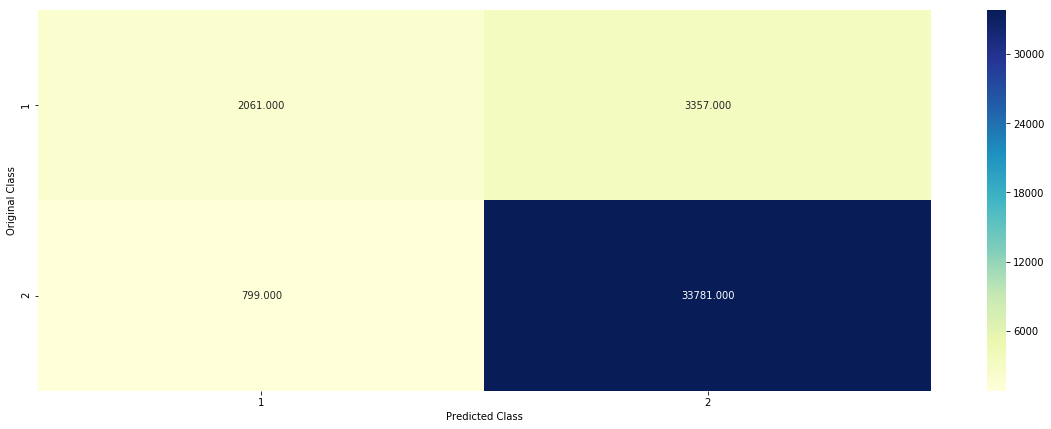

-------------------- Precision matrix (Columm Sum=1) --------------------


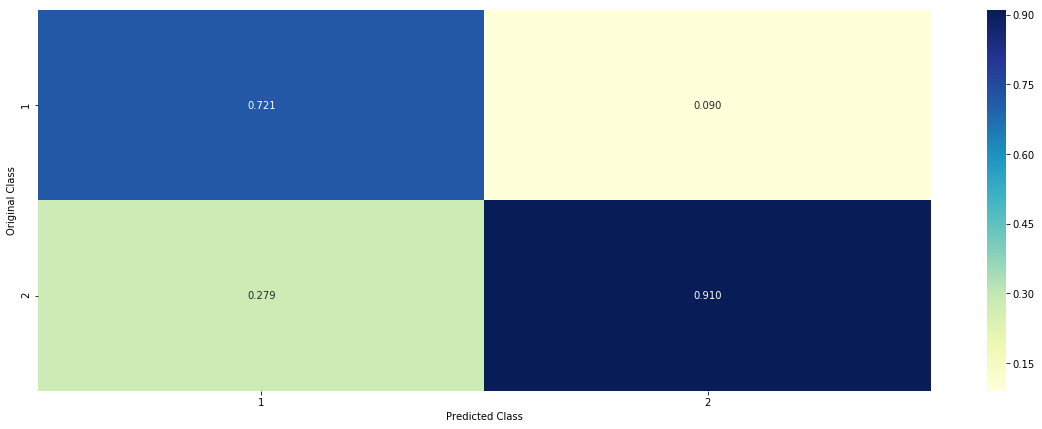

-------------------- Recall matrix (Row sum=1) --------------------


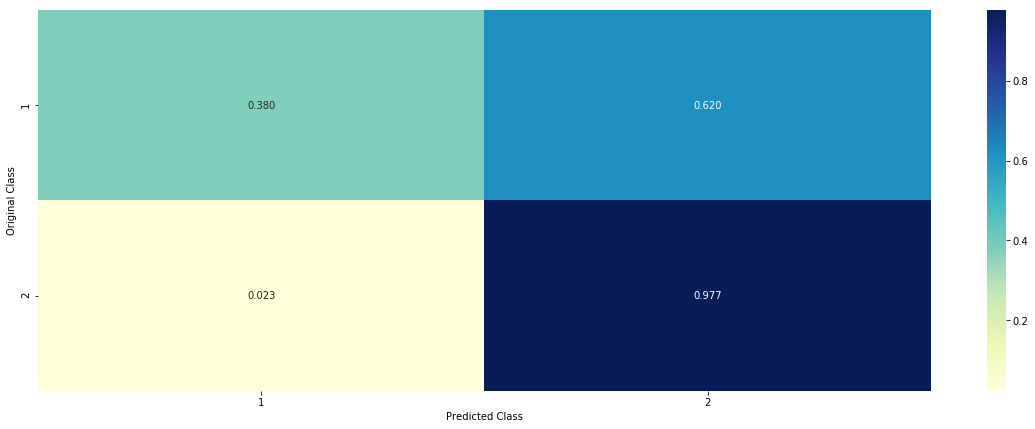

In [52]:
plot_confusion_matrix(Y_test,Y_predict_word2vec)

# tfidfword2vec

In [1]:
tfidf_feat = count_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_X_train_word2vec: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = X_train_vect[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
            
        except:
            pass
    try:    
        sent_vec /= weight_sum
    except ZeroDivisionError:
        sent_vec=0
        
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

NameError: name 'count_vect' is not defined

In [134]:
tfidf_feat = count_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_X_test_word2vec: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = X_test_vect[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    try:    
        sent_vec /= weight_sum
    except ZeroDivisionError:
        sent_vec=0
    #print(sent_vec)
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

In [141]:
tfidf_sent_vectors_train=np.nan_to_num(tfidf_sent_vectors_train)

In [142]:
tfidf_sent_vectors_test = np.nan_to_num(tfidf_sent_vectors_test)

In [157]:
transformer_tfidfword2vec = Normalizer().fit(tfidf_sent_vectors_train)
X_train_vect_norm_tfidfword2vec=transformer_tfidfword2vec.transform(tfidf_sent_vectors_train)

Normalizer(copy=True, norm='l2')


MemoryError: 

In [136]:
X_test_vect_norm_tfidfword2vec=transformer_tfidfword2vec.transform(tfidf_sent_vectors_test)

In [144]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]

model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1', cv=5)
model.fit(X_train_vect_norm_tfidfword2vec, Y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.9369890439908793


In [165]:
clf_model=LogisticRegression(C=1, penalty='l2')
clf = clf_model.fit(X_train_vect_norm_tfidfword2vec, Y_train)
y_train_pred=clf_model.predict(X_train_vect_norm_tfidfword2vec)
Y_predict_tfidfword2vec=clf_model.predict(X_test_vect_norm_tfidfword2vec)

-------------------- Confusion matrix --------------------


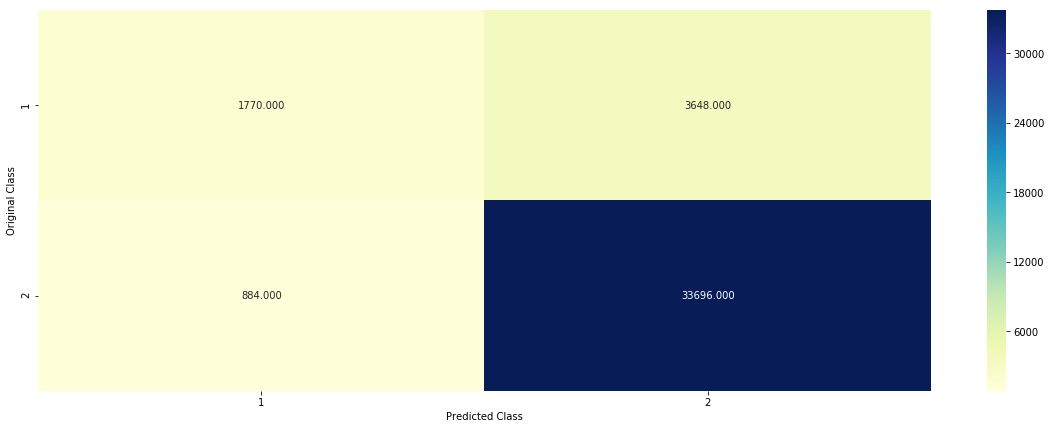

-------------------- Precision matrix (Columm Sum=1) --------------------


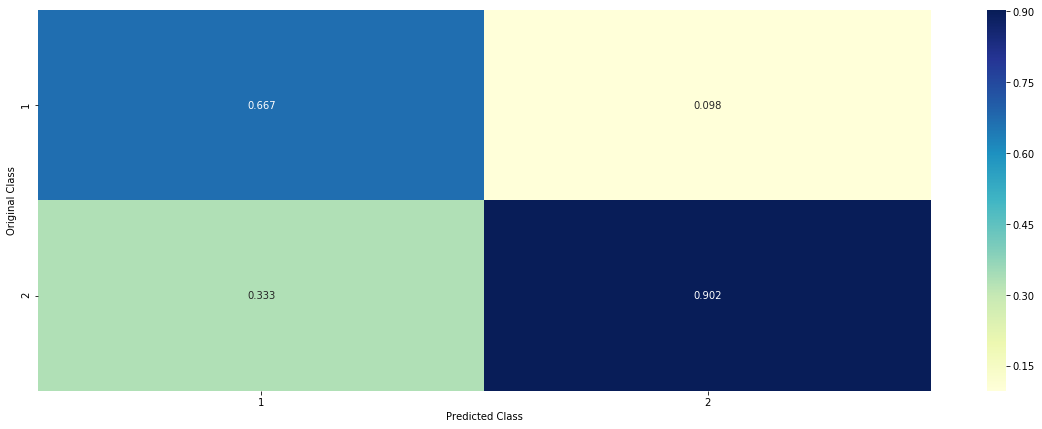

-------------------- Recall matrix (Row sum=1) --------------------


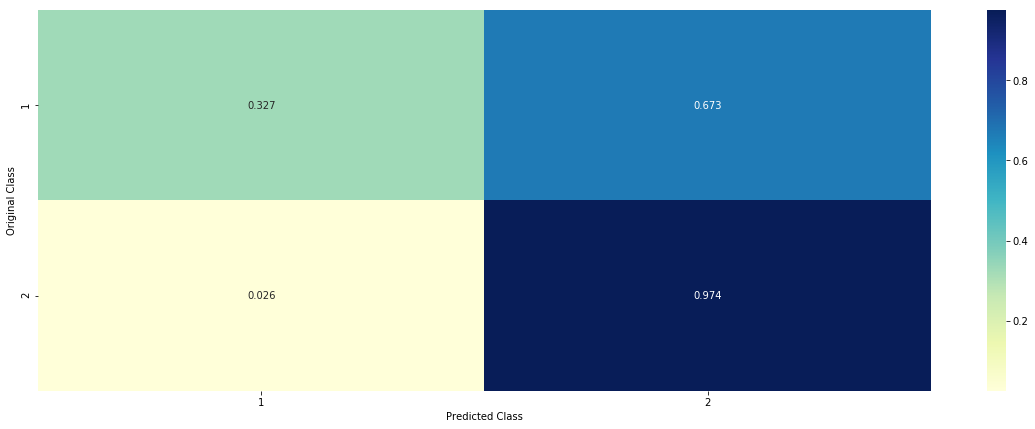

In [151]:
plot_confusion_matrix(Y_test,Y_predict_tfidfword2vec)

In [152]:
from sklearn import metrics

In [161]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test,Y_predict_tfidfword2vec)

In [162]:
metrics.auc(fpr,tpr)

0.6505624526432359

In [166]:
fpr, tpr, thresholds = metrics.roc_curve(Y_train,y_train_pred)

In [167]:
metrics.auc(fpr, tpr)

0.6392813304220567